<a href="https://colab.research.google.com/github/halloweex/data-analysis/blob/master/Breach_Portal_Analysis_Chebotarov.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Breach Portal Data Analysis

Import needed libraries

In [5]:
import time
import pandas as pd
import json
from jsonschema import validate, ValidationError
import datetime
import requests
from bs4 import BeautifulSoup
from selenium.webdriver.common.by import By
from selenium import webdriver as wb
import glob
import os
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import ipywidgets as widgets
from IPython.display import display
import plotly.io as pio
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from wordcloud import WordCloud

## Data Collection (web scraping)

To scrape the website https://ocrportal.hhs.gov/ocr/breach/breach_report.jsf Selenium and BeautifulSoup libraries will be used. As website has JS elements like clicking buttons for expanding info or getting next page etc. And BS suits for quick parsing of HTML.

In [ ]:
def get_table_row(rows):
    """function to scrape table from the website.
    Input rows: rows of the table."""
    
    name_of_entity = []
    state = []
    entity_type = []
    individuals = []
    submission_date = []
    breach_type = []
    location = []
    association = []
    description = []
    data = []
    
    for row in rows:
        name_of_entity.append(row.find_all('td')[1].text)
        state.append(row.find_all('td')[2].text)
        entity_type.append(row.find_all('td')[3].text)
        individuals.append(row.find_all('td')[4].text)
        submission_date.append(row.find_all('td')[5].text)
        breach_type.append(row.find_all('td')[6].text)
        location.append(row.find_all('td')[7].text)
        data.append(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
    
    time.sleep(3)
    
    #scrape the info from hide button
    exp_butn = br.find_element(By.XPATH,"//*[@id='ocrForm:reportResultTable:j_idt372']")
    exp_butn.click()
    time.sleep(30)
    soup_2 = BeautifulSoup(br.page_source, 'html.parser')
    original_info = [i.text for i in soup_2.find_all('td', attrs={'class': 'ui-panelgrid-cell column2'})]
    association.extend(original_info[0::2])
    description.extend(original_info[1::2])
    
    return (name_of_entity, state, entity_type, individuals, submission_date,
            breach_type, location, association, description, data)
    
def reports_scraper(br, count_pages, reports = 'OCR_Breaches_Current'):
    """function to scrape all the reports.
    Inputs br: webdriver,
    count_pages: number of pages to be scraped,
    reports: current or archieved."""
    
    all_reports_data = []
    #find the next page button element
    next_page_button = br.find_element(By.XPATH, '//*[@id="ocrForm:reportResultTable_paginator_bottom"]/a[3]')

    for p in range(1, count_pages):
        time.sleep(60)
        
        #fetch the table rows
        soup_1 = BeautifulSoup(br.page_source, 'html.parser')
        lst = soup_1.find_all('tbody', attrs={'id': 'ocrForm:reportResultTable_data'})
        rows = lst[0].find_all('tr')
        
        report_data = get_table_row(rows)
        
        all_reports_data.append(report_data)
        
        #click the next page button
        next_page_button.click()
        time.sleep(6)
    
    #save each report as a separate JSON file
    for i, report_data in enumerate(all_reports_data):
        report_dict = {
            'Name of Covered Entity': report_data[0],
            'State': report_data[1],
            'Covered Entity Type': report_data[2],
            'Individuals Affected': report_data[3],
            'Breach Submission Date': report_data[4],
            'Type of Breach': report_data[5],
            'Location of Breached Information': report_data[6],
            'Business Associate Present': report_data[7],
            'Web Description': report_data[8],
            'Date_Scraped': report_data[9],
            'Category': reports
        }
        
        file_name = f"{reports}_{i}.json"
        with open(file_name, 'w') as json_file:
            json.dump(report_dict, json_file)


In [ ]:
def ocrportal_scraper(path_to_webdriwer):
    """function to scrape needed website
    Input path_to_webdriwer: path to webdriver local or on server"""
    
    # using webdriwer to navigate through website
    chrome_options = ChromeOptions()
    br = wb.Chrome(f'{path_to_webdriwer}', chrome_options=chromeOptions)
    
    # scrape current reports
    br.get('https://ocrportal.hhs.gov/ocr/breach/breach_report.jsf')
    time.sleep(4)
    
    # get the number of pages
    pages = br.find_element(By.XPATH,'//*[@id="ocrForm:reportResultTable_paginator_bottom"]/span[1]').text
    count_pages = int(pages.replace(')', '').split(' ')[-1])//100 + 2
    
    reports_scraper(br, count_pages, reports = 'OCR_Breaches_Current')
    
    # archive_button
    br.find_element(By.XPATH,'//*[@id="ocrForm:j_idt26"]').click()
    #number of pages
    pages = br.find_element(By.XPATH,'//*[@id="ocrForm:reportResultTable_paginator_bottom"]/span[1]').text
    count_pages = int(pages.replace(')', '').split(' ')[-1])//100 + 2
    
    reports_scraper(br, count_pages, reports = 'OCR_Breaches_Archive')
    
    # close the webdriver
    br.quit()

## Data Validation

In [ ]:
# desired schema of JSON file
schema = {
    'Name of Covered Entity': str,
    'State': str,
    'Covered Entity Type': str,
    'Individuals Affected': int,
    'Breach Submission Date': str,
    'Type of Breach': str,
    'Location of Breached Information': str,
    'Business Associate Present': str,
    'Web Description': str,
    'Date_Scraped': str,
    'Category': str
}

def validate_json_data(json_data, schema):
    """function for JSON validstion based on scema.
    Input json_data: json,
    schema: needed schema of json."""
    try:
        # validate the JSON data against the schema.
        validate(instance=json_data, schema=schema)
        
        # check if all expected fields are present.
        missing_fields = set(schema.keys()) - set(json_data.keys())
        if missing_fields:
            print(f"JSON data is missing the following fields: {missing_fields}")
        else:
            print("JSON data is valid.")
    except ValidationError as e:
        print(f"JSON data is not valid. Error: {e.message}")


Option 1. Validation of JSON function can be added to ocrportal_scraper function, to validate the file in the process of webscraping.

In [ ]:
#it can be done by inserting this piece of code to ocrportal_scraper

with open('JSON_file_name') as json_file:
    json_data = json.load(json_file)

validation_result = validate_json_data(json_data, schema) 

JSON data is valid.


Option 2. To open, read, and validate all JSON files created by the scraper function, can use the glob module to get a list of all JSON files in a directory.

In [ ]:
def validate_all_json_files(directory):
    """open, read, and validate all JSON files in a directory"""
    
    #get a list of all JSON files in the directory
    json_files = glob.glob(directory + "/*.json")
    
    for file in json_files:
        with open(file, 'r') as json_file:
            #read the contents of the file
            file_contents = json_file.read()
            
            #parse the JSON data
            json_data = json.loads(file_contents)
            
            #validate the JSON data
            validate_json_data(json_data, schema)

In [ ]:
directory = 'path_to_directory'
validate_all_json_files(directory)

JSON data is valid.
JSON data is valid.
JSON data is valid.
JSON data is valid.
JSON data is valid.
JSON data is valid.
JSON data is valid.
JSON data is valid.
JSON data is valid.
JSON data is valid.
JSON data is valid.


## Data Visualization

creating a dataframe from files

In [ ]:
path_to_directory = Path(input("Enter the path of your directory: "))
data = []  # list to store the loaded JSON data 
# iterate over the files in the directory
for filename in os.listdir(path_to_directory):
    if filename.endswith('.json'):  #check if the file is a JSON file
        file_path = os.path.join(directory, filename)
        with open(file_path) as json_file:
            json_data = json.load(json_file)
            data.append(json_data)

# create a DataFrame from the collected data
df = pd.DataFrame(data)


1. Let's define which states have the highest frequency of breaches. This can help identify regions that may require additional cybersecurity measures or regulatory attention.



In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
df1 = pd.read_csv('/content/drive/MyDrive/Breach_analysis/new_reports.csv')
df2 = pd.read_csv('/content/drive/MyDrive/Breach_analysis/archive_reports.csv')
df = pd.concat([df1, df2])

In [37]:
# create interactive dropdown widget
dropdown = widgets.Dropdown(
    options=['State', 'Covered Entity Type'],
    value='State',
    description='Category:',
    layout=widgets.Layout(width='200px')
)

# create empty output widget to display the charts
output = widgets.Output()

def update_chart(category):
    # calculate the count of breaches by the selected category
    counts = df[category].value_counts()

    # create the bar chart
    fig = go.Figure(data=[go.Bar(x=counts.index, y=counts.values)])

    # customize the chart layout
    fig.update_layout(
        title=f"Count of Breaches by {category}",
        xaxis_title=category,
        yaxis_title="Count",
        bargap=0.4,
        showlegend=False
    )

    with output:
        output.clear_output()
        fig.show()

def dropdown_change(change):
    """a function to handle dropdown value change"""
    with output:
        output.clear_output()
        update_chart(change.new)

# attach the dropdown value change event handler
dropdown.observe(dropdown_change, names='value')

display(dropdown)
display(output)
update_chart(dropdown.value)

Dropdown(description='Category:', layout=Layout(width='200px'), options=('State', 'Covered Entity Type'), valu…

Output()

2. Let's analyze the distribution of breach types to understand the most common types of security breaches affecting the covered entities. This information can help prioritize security measures and allocate resources accordingly.

In [15]:
# preparation of Type of Breach
df_new = df
df_new['Type of Breach'] = df_new['Type of Breach'].str.split(', ')
df_new = df_new.explode('Type of Breach')

In [16]:
# clculate the count of each breach type
breach_counts = df_new['Type of Breach'].value_counts()
breach_percentages = breach_counts / breach_counts.sum()

# identify breach types with less than 1% occurrence
threshold = 0.01
other_types = breach_percentages[breach_percentages < threshold].index

# group the breach types by 'Other'
breach_counts_grouped = breach_counts.copy()
breach_counts_grouped.loc[other_types] = breach_counts_grouped.loc[other_types].sum()
breach_counts_grouped.drop(other_types, inplace=True)


chart_data = pd.DataFrame({'Breach Type': breach_counts_grouped.index, 'Count': breach_counts_grouped.values})

# add 'Other' as a new category
other_count = breach_counts.loc[other_types].sum()
chart_data = chart_data.append({'Breach Type': 'Other', 'Count': other_count}, ignore_index=True)

fig = go.Figure(data=[go.Pie(labels=chart_data['Breach Type'], values=chart_data['Count'], hoverinfo='label+percent')])
fig.update_layout(title='Breach Types Distribution (with "Other")')
pio.show(fig)


<ipython-input-16-dad04521be2e>:19: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



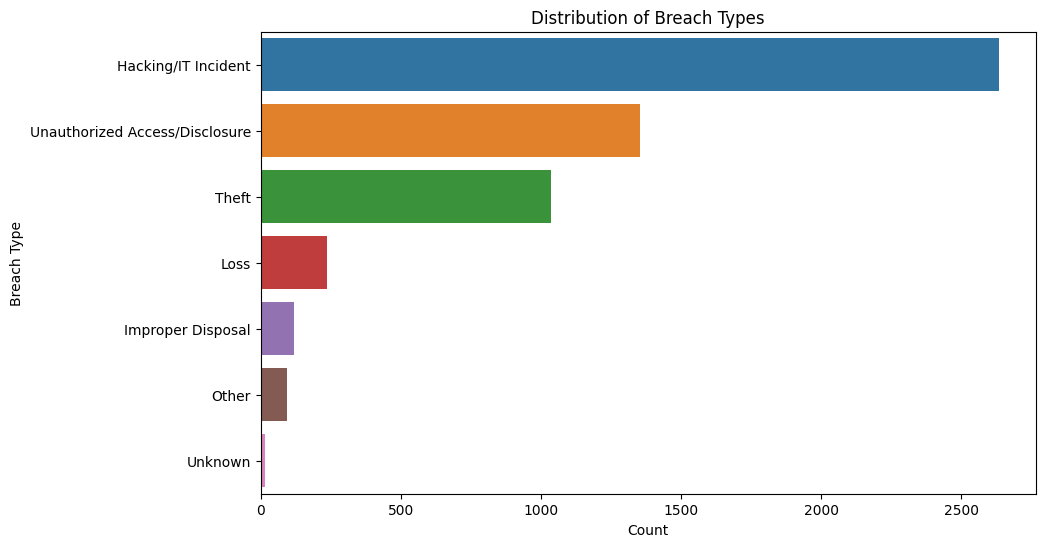

In [17]:
breach_counts = df_new['Type of Breach'].value_counts()

# plot the distribution of breach types
plt.figure(figsize=(10, 6))
sns.countplot(data=df_new, y='Type of Breach', order=breach_counts.index)
plt.xlabel('Count')
plt.ylabel('Breach Type')
plt.title('Distribution of Breach Types')
plt.show()

3. Let's explore the relationship between the number of individuals affected and breach types or covered entity types. This analysis can reveal which breach types or covered entity types tend to have a larger impact on individuals' personal information, highlighting areas that require enhanced security measures.

In [18]:
breach_type_data = df_new.groupby('Type of Breach')['Individuals Affected'].sum().reset_index()

# group by covered entity type and calculate the sum of individuals affected
covered_entity_data = df_new.groupby('Covered Entity Type')['Individuals Affected'].sum().reset_index()

fig_breach_types = px.bar(breach_type_data, x='Type of Breach', y='Individuals Affected',
                          title='Number of Individuals Affected by Breach Types',
                          labels={'Individuals Affected': 'Number of Individuals Affected'},
                          hover_name='Type of Breach')

fig_covered_entity = px.bar(covered_entity_data, x='Covered Entity Type', y='Individuals Affected',
                            title='Number of Individuals Affected by Covered Entity Types',
                            labels={'Individuals Affected': 'Number of Individuals Affected'},
                            hover_name='Covered Entity Type')

fig_breach_types.show()
fig_covered_entity.show()

4. Let's try to discover if this can help identify any trends or patterns in the number of affected individuals

In [19]:
df['Breach Submission Date'] = pd.to_datetime(df['Breach Submission Date'])

# create the line plot
fig = px.line(df, x='Breach Submission Date', y='Individuals Affected', title='Number of Individuals Affected Over Time')

fig.show()


In [20]:
#check the incident on Feb 2015
df[(df['Breach Submission Date'] >= '2015-02-01') & (df['Breach Submission Date'] <= '2015-02-28')]

,Unnamed: 0,Name of Covered Entity,State,Covered Entity Type,Individuals Affected,Breach Submission Date,Type of Breach,Location of Breached Information,Business Associate Present,Web Description,Date_Scraped,Category
3258,3258,Aventura Hospital and Medical Center,FL,Healthcare Provider,686.0,2015-02-27,[Unauthorized Access/Disclosure],"Desktop Computer, Electronic Medical Record",No,NaN,2023-05-25 16:49:44,OCR_Breaches_Archive
3259,3259,"Cathrine Steinborn, DDS",CA,Healthcare Provider,3224.0,2015-02-27,[Theft],Network Server,No,The covered entity (CE) reported a breach of 3...,2023-05-25 16:49:44,OCR_Breaches_Archive
3260,3260,"St.Vincent Hospital and Health Care Center, Inc.",IN,Healthcare Provider,63325.0,2015-02-27,[Unauthorized Access/Disclosure],Paper/Films,No,"The covered entity (CE), St. Vincent Health, m...",2023-05-25 16:49:44,OCR_Breaches_Archive
3261,3261,"Raymond Mark Turner, M.D.",NV,Healthcare Provider,2153.0,2015-02-26,[Theft],Laptop,No,One unencrypted laptop computer was stolen dur...,2023-05-25 16:49:44,OCR_Breaches_Archive
3262,3262,Children's National Medical Center,DC,Healthcare Provider,18000.0,2015-02-24,[Hacking/IT Incident],Email,No,"Employees of the covered entity (CE), Children...",2023-05-25 16:49:44,OCR_Breaches_Archive
3263,3263,Marketing Clique,TX,Health Plan,8700.0,2015-02-20,[Unauthorized Access/Disclosure],Other,Yes,The business associate (BA) of Lone Star Circl...,2023-05-25 16:49:44,OCR_Breaches_Archive
3264,3264,Hunt Regional Medical Partners,TX,Healthcare Provider,3000.0,2015-02-18,[Unauthorized Access/Disclosure],Other,No,Vandals broke into a building storing paper pr...,2023-05-25 16:49:44,OCR_Breaches_Archive
3265,3265,Anthem Inc.,IN,Health Plan,78800000.0,2015-02-13,[Hacking/IT Incident],Network Server,No,"Anthem, Inc. has agreed to pay $16 million to ...",2023-05-25 16:49:44,OCR_Breaches_Archive
3266,3266,Pathway to Hope,FL,Healthcare Provider,600.0,2015-02-12,[Unauthorized Access/Disclosure],Email,No,"The covered entity (CE), Pathway to Hope, disc...",2023-05-25 16:49:44,OCR_Breaches_Archive
3267,3267,Courier Corporation of Hawaii,HI,Business Associate,2809.0,2015-02-11,[Loss],Paper/Films,Yes,Documents containing the protected health info...,2023-05-25 16:49:44,OCR_Breaches_Archive


In [21]:
#description of that incident
df.loc[3265]['Web Description']

'Anthem, Inc. has agreed to pay $16 million to the U.S. Department of Health and Human Services, Office for Civil Rights (OCR) and take substantial corrective action to settle potential violations of the Health Insurance Portability and Accountability Act (HIPAA) Privacy and Security Rules after a series of cyberattacks led to the largest U.S. health data breach in history and exposed the electronic protected health information of almost 79 million people.\n\nOn March 13, 2015, Anthem filed a breach report with the HHS Office for Civil Rights detailing that, on January 29, 2015, they discovered cyber-attackers had gained access to their IT system via an undetected continuous and targeted cyberattack for the apparent purpose of extracting data, otherwise known as an advanced persistent threat attack.  After filing their breach report, Anthem discovered cyber-attackers had infiltrated their system through spear phishing emails sent to an Anthem subsidiary after at least one employee resp

In [22]:
grouped_data = df.groupby(df['Breach Submission Date'].dt.year)['Individuals Affected'].sum()
grouped_data.reset_index()

,Breach Submission Date,Individuals Affected
0,2009,134773.0
1,2010,5932276.0
2,2011,13162158.0
3,2012,2854525.0
4,2013,7018839.0
5,2014,19073551.0
6,2015,112466720.0
7,2016,16712554.0
8,2017,5313996.0
9,2018,14232822.0


5. Let's find insights into the frequency of breaches during different periods.

In [23]:
# create the histogram using Plotly Express
fig = px.histogram(df, x='Breach Submission Date', nbins=30, title='Frequency of Breaches Over Time')
fig.update_layout(xaxis_title='Breach Submission Date', yaxis_title='Frequency')

fig.show()

6. Let's plot the relationship between the number of individuals affected and the breach submission date using a scatter plot. This can help identify any correlation or patterns between these variables.

In [24]:
fig = px.scatter(df, x='Breach Submission Date', y='Individuals Affected',
                 title='Number of Individuals Affected vs. Breach Submission Date')
fig.update_layout(xaxis_title='Breach Submission Date', yaxis_title='Number of Individuals Affected')


fig.show()

7. Let's investigate the location of breached information to identify common vulnerabilities or targets. This analysis can inform targeted security measures and highlight areas where additional safeguards may be necessary.

In [25]:
df_new['Location of Breached Information'] = df_new['Location of Breached Information'].str.split(', ')
df_new = df_new.explode('Location of Breached Information')

location_counts = df_new['Location of Breached Information'].value_counts()

# Print the top 10 most common locations
top_10_locations = location_counts.head(10)
print(top_10_locations)

Network Server                      1928
Email                               1285
Paper/Films                          923
Laptop                               513
Other                                432
Electronic Medical Record            387
Desktop Computer                     380
Other Portable Electronic Device     340
Name: Location of Breached Information, dtype: int64


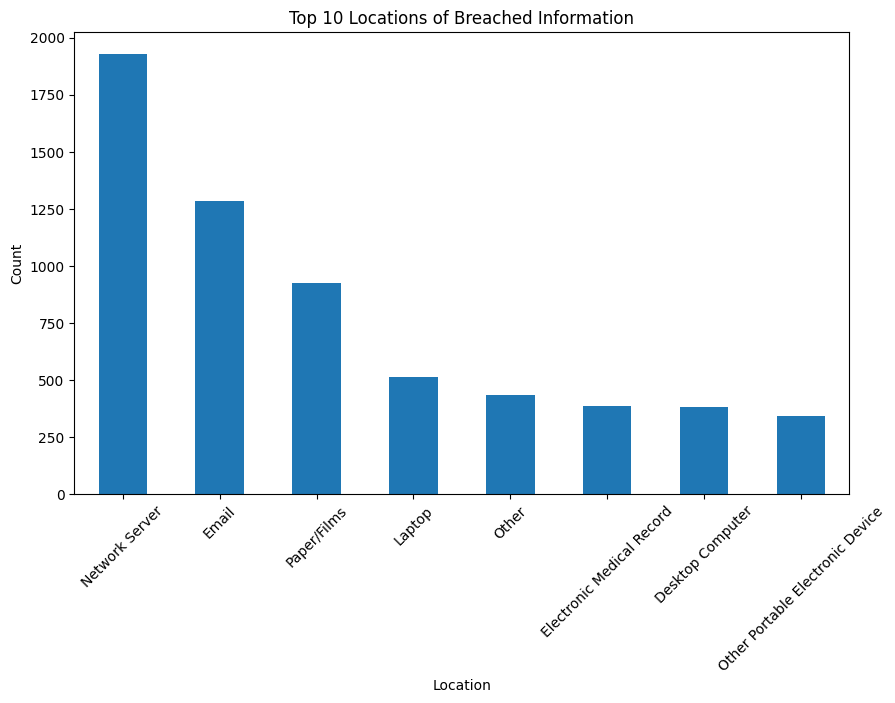

In [26]:
# Plot a bar chart to visualize the location counts
plt.figure(figsize=(10, 6))
top_10_locations.plot(kind='bar')
plt.title('Top 10 Locations of Breached Information')
plt.xlabel('Location')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

8. Let's evaluate the presence of business associates in breaches and explore any correlations between breach severity or impact and the involvement of business associates. This analysis can shed light on the role of business associates in breaches and the need for stricter oversight or contractual obligations.

In [27]:
# count the number of breaches based on the presence or absence of business associates
business_associate_counts = df['Business Associate Present'].value_counts().reset_index()

# Create an interactive bar plot using Plotly
fig = px.bar(business_associate_counts, x='index', y='Business Associate Present', 
             labels={'index': 'Business Associate Present', 'Business Associate Present': 'Count'},
             title='Count of Breaches by Business Associate Presence')

fig.show()


9. Let's analyze the textual descriptions of breaches to identify common themes, attack vectors, or recurring patterns. This can provide insights into emerging cybersecurity threats or areas where organizations may need to bolster their defenses.

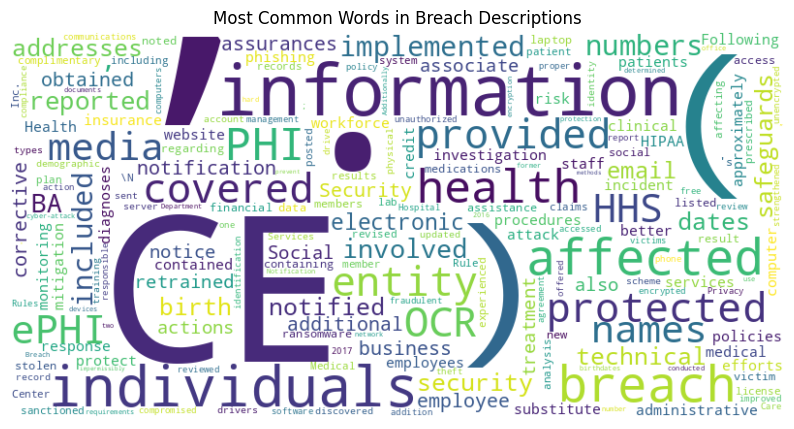

In [36]:
all_descriptions = ' '.join(df['Web Description'].dropna())

# tokenize the text into individual words
tokens = word_tokenize(all_descriptions)

# remove stopwords
stop_words = set(stopwords.words('english'))
filtered_tokens = [word for word in tokens if word.lower() not in stop_words]

# calculate word frequency
freq_dist = FreqDist(filtered_tokens)

# plot the most common words in a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(freq_dist)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Breach Descriptions')
plt.show()


Let's the frequency of breach reports for different covered entities. By examining the "Name of Covered Entity" column, we can identify the entities with a higher frequency of breach reports. 

In [29]:
# extract the "Name of Covered Entity" column from the dataframe
covered_entity_names = df['Name of Covered Entity']

# calculate the frequency of each unique name
name_frequencies = covered_entity_names.value_counts()
sorted_frequencies = name_frequencies.sort_values(ascending=False)

# display the top 10 entities with the highest frequency of breach reports
top_10_entities = sorted_frequencies.head(10)
print(top_10_entities)

Walgreen Co.                                                          17
Humana Inc                                                             9
Brightline, Inc.                                                       9
Aetna ACE                                                              8
Henry Ford Health System                                               8
Walmart Inc.                                                           8
Health Care Service Corporation                                        6
Montefiore Medical Center                                              6
Washington University School of Medicine                               6
dormant see master file 489659_ Benefit Plan Administrators, Inc.      6
Name: Name of Covered Entity, dtype: int64


In [30]:
fig = go.Figure(data=[go.Bar(
    x=top_10_entities.index,
    y=top_10_entities.values,
    marker_color='purple'
)])

fig.update_layout(
    title='Top 10 Covered Entities with Highest Frequency of Breach Reports',
    xaxis=dict(title='Covered Entity'),
    yaxis=dict(title='Frequency'),
    xaxis_tickangle=-45,
    bargap=0.2,
    showlegend=False
)

fig.show()

